# Now that we have produced some light curves with potential planet candidates, we can start doing some more careful followup analysis on a case by case basis.

Some things to check for are:
- Eclipsing Binaries (can be identified by phase folding from 0 to 1 instead of centered on transit time and then checking for different transit depths of primary and secondary events)
- Poor detrending (maybe our big net approach missed some things. We can tweak our pipeline to see if it improves)



In [1]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)


from transitleastsquares import catalog_info
from transitleastsquares import period_grid
from transitleastsquares import transitleastsquares

import warnings
# warnings.filterwarnings(action='once') #useful to see a warning once but that's it
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses


import wotan
from wotan import flatten


from astroML.time_series import lomb_scargle

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)


#-========= Karen's inverse weighted binning function ++++
def Bin_func(time,flux,error,binsize):
    good = np.where(np.isfinite(time))
    timefit = time[good]
    fluxfit = flux[good]
    errfit  = error[good]
    timemax = np.max(timefit)
    timemin = np.min(timefit)
    npoints = len(timefit)
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days
    bintime = np.full((nbins,), np.nan)
    binflux = np.full((nbins,), np.nan)
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )]
        if tobin[0] != -1:
    #     inverse variance weighted means
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime))
    bintime = bintime[good2]
    binflux = binflux[good2]
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr

## Let's load in our data

In [2]:
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)



1
TESS Sector 01
number of files:  917


# From the Google Spreadsheet, you can select individual planet candidate targets that look interesting and paste their TIC IDs here:

In [14]:
ID = 52194549 #For example

# With this TIC ID, we can check if this light curve exists in our data set:

In [15]:
match = [i for i in data if str(ID) in i][0]  #; print(len(match))
print("Match!", match)

Sector = "S"+(os.path.basename(match).split)('_')[1][1:] 
Camera = (os.path.basename(match).split)('_')[2] 
CCD = (os.path.basename(match).split)('_')[3][-4]

Match! /Users/felizd/Desktop/TESS/Sector01/curves/clean/52194549_sector01_3_1.lc


# Let's plot it

pre-processed lightcurve from Filtergraph: 


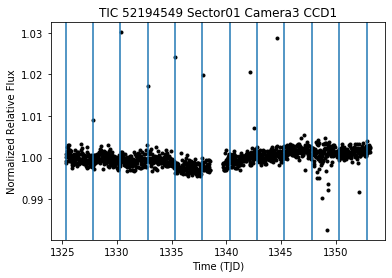

^^^ momentum dumps are blue vertical lines ^^^


In [16]:
t = np.transpose(np.loadtxt(match))[0]
m = np.transpose(np.loadtxt(match))[1]
me = np.transpose(np.loadtxt(match))[2]

f = 10.0**(m/-2.5)/np.mean(10.0**(m/-2.5)) #converted to flux and normalized
fe = f*(10.0**(me/2.5)-1.0) #converting magnitude errors to flux errors


print("pre-processed lightcurve from Filtergraph: ")

plt.title("TIC "+str(ID)+" "+Sector+" Camera"+Camera+" CCD"+CCD)
plt.plot(t,f,'k.')
plt.xlabel("Time (TJD)")
plt.ylabel("Normalized Relative Flux")


#momentum dumps:
mdumps=2.5 #for sector 1
Num_mdumps = int(np.round((t[-1]-t[0])/mdumps,2))+1

for x in range(Num_mdumps):
    plt.axvline(t[0]+2.5*x)

plt.show()

print("^^^ momentum dumps are blue vertical lines ^^^")

# Lets recreate our pipeline result and see what this lightcurve looks like when cleaned up

 
LS period:  0.6138944717558491
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 131 durations
Searching 1082 data points, 4303 periods from 1.1 to 13.917 days
Using all 4 CPU threads
 
TIC  52194549   1   3   Sector01
best period:  12.029469785565933
best T0:  1330.24478961815


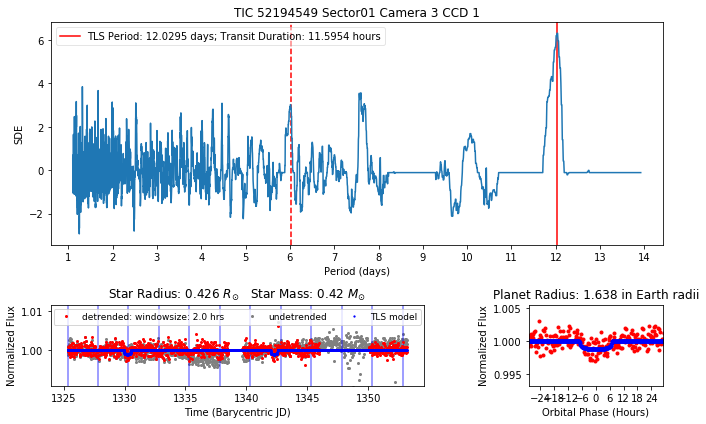

In [23]:
mask = np.where(np.isfinite(f)==True)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
time = t[mask]                        #Sometimes there are holes in data filled with NaNs
flux = f[mask]
fluxerror = fe[mask]


#known bad data points with high telescope jitter:
SectorNum = int((os.path.basename(match).split)('_')[1][6:])
if SectorNum==1:
    jittermask = (time < 1346) | (time > 1350)
    mdumps=2.5


    t1,f1,fe1 = time[jittermask], flux[jittermask], fluxerror[jittermask]

    t2,f2,fe2=t1,f1,fe1
else:

    t2,f2,fe2=time,flux,fluxerror

if SectorNum==3:
    jittermask = (time < 1382.6) | (time > 1383.65)
    mdumps=3.125

    t1,f1,fe1 = time[jittermask], flux[jittermask], fluxerror[jittermask]

    t2,f2,fe2=t1,f1,fe1

if SectorNum==2:
    mdumps=2.5
    t2,f2,fe2=time,flux,fluxerror     
    
    
    
#check for rapid rotators with Lomb-Scargle (P_rot < 3 days)
period = 10 ** np.linspace(np.log10(0.1), np.log10(3), 1000)
#     period = 10 ** np.linspace(np.log10(0.1), np.log10(80), 1000)
freq = 2.0 * np.pi / period
PS = lomb_scargle(t2,f2,fe2,omega=freq, generalized=True)
Standpower = (PS-np.mean(PS))/np.std(PS)
print(" ")    
print("LS period: ",period[np.argmax(Standpower)])

if period[np.argmax(Standpower)] < 3:

    print("Applying Quasi Periodic GP...")
    length_scale=2 # 1 to 2 is generally pretty good from my tests
    gpflatten_lc, gptrend_lc = flatten(t2,f2,method='gp', \
                                         kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)

    T=t2
    F= gpflatten_lc
    FE = fe2
    
    T,F,FE = ChauventsCriteron(T,F,FE)
    flatten_lc, trend_lc = flatten(T,F,method='savgol',window_length=241,cval=3,return_trend=True)


    nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
    T = T[nanmask]
    F = flatten_lc[nanmask]/np.mean(flatten_lc[nanmask])
    FE =FE[nanmask]

    window_size_wotan = length_scale/24.0
else:

    print("Applying Biweighted Midcorrelation Function...")
    window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, break_tolerance=window_size_wotan/2.0,method='biweight',robust=True)
    T=t2
    F=flatten_lc
    FE=fe2

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]

    T,F,FE = ChauventsCriteron(T,F,FE)

#checking for NaNs
nanmask = np.where(np.isfinite(F)==True)[0]
T = T[nanmask]
F = F[nanmask]
FE =FE[nanmask]

qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
spacing = 0.02

SDE_threshold=6.0 #we've been testing different values here (6,6.5,7). For now, let's try sticking with 6.
 
fs = 9

#for reporting TLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
    minP=1.1
    maxP= (max(T)-min(T)) #length of our light curve
    minDur = 1.0/24.0
    maxDur = 5.0/24.0

    #creating list of orbital periods to model with
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

    durations = np.linspace(minDur,maxDur,25)

    tls = transitleastsquares(T,F,FE)
    tls_power = tls.power(R_star=R_star,period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=2,duration_grid_step=1.02)

    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power
    TLS_Dur = tls_power.duration

    #calculating TLS estimated planet radius
    R_p = np.sqrt(1-TLS_depths)*R_star*R_sun/R_earth

    #creating the best fit box model to our data
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model 

    p = TLS_periods
    pf_model = (TLS_model_time - TLS_t0s + 0.5*p) % p - 0.5*p        
    x_fold = (T - TLS_t0s + 0.5*p) % p - 0.5*p
    x_fold_raw = (t - TLS_t0s + 0.5*p) % p - 0.5*p

    detrendedphasefoldedlc = [x_fold, F, FE]
    phasefoldedlc = [x_fold_raw, f, fe]


#     if len(np.where(TLS_SDE>SDE_threshold)[0])>0:
    print(" ")
    print("TIC ", str(ID), " ",CCD, " ",Camera, " ",Sector)
    print("best period: ", TLS_periods)
    print("best T0: ",TLS_t0s)

    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])


    ax1.axvline(x=TLS_periods,color='r',label='TLS Period: '+str( np.round(TLS_periods,4) )+" days; Transit Duration: "+str(np.round(24*TLS_Dur,4))+" hours") #rounding period to 4 decimal places 
    ax1.axvline(x=0.5*TLS_periods,color='r',linestyle='--')
    ax1.axvline(x=2.0*TLS_periods,color='r',linestyle='--') 
    ax1.plot(tls_power.periods, TLS_SDE, rasterized=True)
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title("TIC "+str(ID)+" "+Sector+" Camera "+Camera+" CCD "+CCD)
    ax1.set_xlabel("Period (days)")
    ax1.set_xticks(np.arange(1.0, 15.0, 1.0))
    ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)

    ax1.set_ylabel("SDE")
    ax1.set_ylim(np.min(TLS_SDE)-0.5, np.max(TLS_SDE)+0.5)
    ax1.legend(loc='best',fancybox=True,framealpha=0.5)

    ax2.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')#+", binsize: "+str(bin_size)) 
    ax2.plot(t,f,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
    ax2.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
    ax2.legend(loc='upper center',ncol=3,fontsize=fs)
    ax2.set_ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F))
    for x in range(12):
        ax2.axvline(x=(T[0]+x*mdumps),color='b',alpha=0.5,zorder=0)
    ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")

    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')
    ax3.plot(24*pf_model,TLS_model,'b.',label='TLS model',markersize=5)
    ax3.set_xlabel("Orbital Phase (Hours)")
    ax3.set_ylabel("Normalized Flux") 
    ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
    ax3.set_ylim(np.min(TLS_model)-25*np.std(TLS_model), np.max(TLS_model)+25*np.std(TLS_model))
    ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours

    if TLS_Dur*24> 8.0:
        ax3.set_xticks(np.arange(np.round(-14*TLS_Dur*24.0),np.round(14*TLS_Dur*24.0),6)) #hours
        ax3.set_xlim(-2.5*TLS_Dur*24,2.5*TLS_Dur*24)

    else:
#                     TLS_Dur*24< 1.0 and TLS_Dur*24< 8.0:
        ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours
        ax3.set_xlim(-5,5)

    if TLS_Dur*24< 1.0:
        ax3.set_xticks(np.arange(np.round(-15*TLS_Dur*24.0),np.round(15*TLS_Dur*24.0),1.)) #hours
        ax3.set_xlim(-3*TLS_Dur*24,3*TLS_Dur*24)

    gs1.tight_layout(fig)

#             plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()    


# Looks pretty interesting. The long duration of 11.6 hours throws me off a bit. Let's take a closer look at the data before and after our detrending.

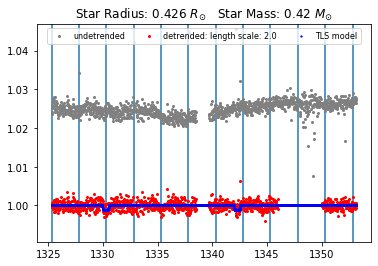

In [70]:
spacing = 0.025


#momentum dumps:
mdumps=2.5 #for sector 1
Num_mdumps = int(np.round((t[-1]-t[0])/mdumps,2))+1

for x in range(Num_mdumps):
    plt.axvline(t[0]+2.5*x)    
plt.plot(t,f+spacing,c='grey',marker='.',markersize=4,linestyle='none',label='undetrended')

plt.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',label='detrended: length scale: '+str(window_size_wotan*24))
plt.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
plt.legend(loc='upper center',ncol=3,fontsize=fs-1)
plt.ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F)+0.01+spacing)


    
plt.title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")

plt.show()

# It looks like there are some wiggles being exaggerated and subtracted in our detrending. Let's try again with a some tweakable parameters:

In [107]:
# Change these parameters around to refine the detrending process

def momentumdump_removal(SectorNum,before_after_in_minutes, time, flux, flux_error):
#     print("before: ",len(time),len(flux),len(flux_error))
    if SectorNum==1:
        jittermask = (time < 1346) | (time > 1350)
        mdumps=2.5

        t2,f2,fe2=time[jittermask], flux[jittermask], flux_error[jittermask]

    elif SectorNum==3:
        jittermask = (time < 1382.6) | (time > 1383.65)
        mdumps=3.125

        t2,f2,fe2=time[jittermask], flux[jittermask], flux_error[jittermask]

    if SectorNum==2:
        mdumps=2.5
        t2,f2,fe2=time,flux,flux_error  #I haven't yet identified bad regions of data for Sector 2
        
    Num_mdumps = int(np.round((t2[-1]-t2[0])/mdumps,2))
    before_after = before_after_in_minutes/(60.0*24.0) # in days
    
    tt,ff,fefe = t2,f2,fe2
    
    for N in range(Num_mdumps):
        time_mdump = tt[0]+N*mdumps
        minus = time_mdump - before_after
        plus  = time_mdump + before_after
        mask_mdump = (tt < minus) | (tt > plus)
        
        tt,ff,fefe = tt[mask_mdump], ff[mask_mdump], fefe[mask_mdump]
        
    print("N pts before: ",len(time)," N pts after: ", len(tt))
    return tt,ff,fefe
        
        

# removing regions of bad data by visually identifying a range of data
def remove_bad_data(time,flux,flux_error, badtime1, badtime2):
    bad_data_mask = (time < badtime1) | (time > badtime2)
    
    return time[bad_data_mask], flux[bad_data_mask], flux_error[bad_data_mask]

# Filters

#BiWeighted MidCorrelation robust filter
def BWMC(window_size_in_hrs,time,flux,flux_error): #bt = break tolerance, pipeline uses window_size/2.0
    
    window_size = window_size_in_hrs/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size, return_trend=True, break_tolerance=window_size_wotan/2.0,method='biweight',robust=True)
    T=time
    F=flux
    FE=flux_error

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    return T,F,FE
  
#Quasi-Periodic Gaussian Process Detrending
def GP(length_scale,time,flux,flux_error):
    length_scale=length_scale # 1 to 2 is generally pretty good from my tests
    gpflatten_lc, gptrend_lc = flatten(time,flux,method='gp', \
                                         kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)

    T=time
    F= gpflatten_lc
    FE = flux_error

    nanmask = np.where(np.isfinite(gpflatten_lc)==True)[0]
    T = T[nanmask]
    F = gpflatten_lc[nanmask]/np.mean(gpflatten_lc[nanmask])
    FE =FE[nanmask]
    
    T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    return T,F,FE
    
#Savitsky-Golay Filter
def SG(time,flux,flux_error,window_size_in_hrs,poly_order): #polynomial order is 3 in our pipeline
    cad = time[1]-time[0]
    
    #now let's define a window size to smooth our data with:
    window_size = int(window_size_in_hrs/cad) #number of data points in N hour window
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1
    flatten_lc, trend_lc = flatten(time,flux,method='savgol',window_length=window_size,cval=poly_order,return_trend=True)


    nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
    T = time[nanmask]
    F = flatten_lc[nanmask]/np.mean(flatten_lc[nanmask])
    FE =flux_error[nanmask]
    
    T,F,FE = ChauventsCriteron(T,F,FE)

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]
    
    return T,F,FE


# Putting it all in one function (momentum dump removal + detrending):


In [136]:

# Input=input("What Detrending Method would you like to use? (BWMC, GP, SG) ")
def Detrending_Method(time,flux,error,Input=None):
    
    SectorNum=float(input("Sector Number? (1,2,3,4,5) Answer: "))
    before_after_in_minutes = float(input("How much data to remove before/after momentum dumps? (in minutes) Answer: "))
    time,flux,error = momentumdump_removal(SectorNum,before_after_in_minutes, time,flux,error)
    
    
    
    Input=input("What Detrending Method would you like to use? (BWMC, GP, SG)  Answer: ")
    if Input =="BWMC":
        window=float(input("BWMC window size (in hours)? (5 is default in pipeline)  Answer: "))
        T,F,E = BWMC(window,time,flux,error)
#         print('a')
        
    elif Input == "GP":
        length_scale=float(input("GP length scale? (2 is default in pipeline)  Answer: "))
        T,F,E = GP(length_scale,time,flux,error)
#         print('b')
        
    if Input == "SG":
        window_size_in_hrs=float(input("SG window size (in hours) (5 matches to pipeline)?  Answer: "))
        cad = time[1]-time[0] #cadence of data sampling
        window_size = int(window_size_in_hrs/cad) #number of data points in N hour window
        if (window_size % 2) == 0: #must be odd. If not, there will be an error
            window_size = window_size+1
#         print('c')  
        poly_order = float(input("Polynomial Order? (3 is default)  Answer: "))
        T,F,E = SG(time,flux,error,window_size_in_hrs,poly_order)

    return T,F,E

In [139]:
# SectorNum,before_after_in_minutes = 1, 30.0

print("Method 1"); print("")
t1,f1,e1 = Detrending_Method(t,f,fe)
# t1,f1,e1= momentumdump_removal(SectorNum,before_after_in_minutes, t1,f1,e1)
print("")

print("Method 2")
t2,f2,e2 = Detrending_Method(t,f,fe)
# t2,f2,e2= momentumdump_removal(SectorNum,before_after_in_minutes, t2,f2,e2)
print("")

print("Method 3"); print("")
t3,f3,e3 = Detrending_Method(t,f,fe)
# t3,f3,e3= momentumdump_removal(SectorNum,before_after_in_minutes, t3,f3,e3)

Method 1

Sector Number? (1,2,3,4,5) Answer: 1
How much data to remove before/after momentum dumps? (in minutes) Answer: 30
N pts before:  1282  N pts after:  1071
What Detrending Method would you like to use? (BWMC, GP, SG)  Answer: BWMC
BWMC window size (in hours)? (5 is default in pipeline)  Answer: 5

Method 2
Sector Number? (1,2,3,4,5) Answer: 1
How much data to remove before/after momentum dumps? (in minutes) Answer: 30
N pts before:  1282  N pts after:  1071
What Detrending Method would you like to use? (BWMC, GP, SG)  Answer: GP
GP length scale? (2 is default in pipeline)  Answer: 2
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3

Method 3

Sector Number? (1,2,3,4,5) Answer: 1
How much data to remove before/after momentum dumps? (in minutes) Answer: 30
N pts before:  1282  N pts after:  1071
What Detrending Method would you like to use? (BWMC, GP, SG)  Answer: SG
SG window size (in hours) (5 matches to pipeline)?  Answer: 5
Polynomial Order? (3 is default)  Answer: 3


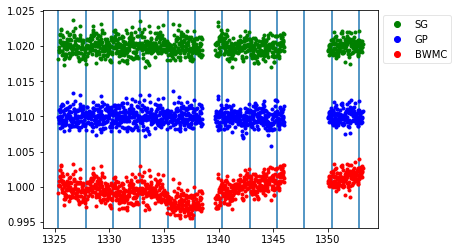

In [140]:
#momentum dumps:
mdumps=2.5 #for sector 1
Num_mdumps = int(np.round((t[-1]-t[0])/mdumps,2))+1
spacing=0.01
for x in range(Num_mdumps):
    plt.axvline(t[0]+2.5*x)    
plt.plot(t3,f3+2*spacing,'g.',label="SG")
plt.plot(t2,f2+spacing,'b.',label="GP")
plt.plot(t1,f1,'r.',label="BWMC")
plt.legend(loc='best',bbox_to_anchor=(1,1),fancybox=True,framealpha=0.5,markerscale=2)
plt.show()

# Now Let's Make a function for TLS with tweakable parameters

In [159]:
def phasefold(T0,time,period):
    return (time- T0 + 0.5*period) % period - 0.5*period        
    


def TLS_func(ID,time,flux,error,minP,minDur,maxDur,N_transits):

    
    qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)


    maxP= (max(time)-min(time)) #length of our light curve

    #creating list of orbital periods to model with
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

    durations = np.linspace(minDur,maxDur,25)

    tls = transitleastsquares(time,flux,error)
    tls_power = tls.power(R_star=R_star,period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=N_transits,duration_grid_step=1.02)
    tls_power_periods = tls_power.periods
    
    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power
    TLS_Dur = tls_power.duration

    #calculating TLS estimated planet radius
    R_p = np.sqrt(1.0-TLS_depths)*R_star*R_sun/R_earth
    
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model 
    return tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur, R_p, TLS_model_time, TLS_model 

def TLS_plot(time,flux,error, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, TLS_model_time, TLS_model):
    
    fs = 9
    spacing = 0.02
    #for reporting TLS model's planet radius
    R_earth = 6.378*10.0**8.0 #cm
    R_sun = 6.955*10.0**10.0 #cm

    
    # phase folding models and data
#     TLS_model_time = tls_power.model_lightcurve_time 
#     TLS_model = tls_power.model_lightcurve_model 

    p = TLS_periods
    pf_model = phasefold(TLS_model_time,TLS_t0s,p)
    x_fold = phasefold(time,TLS_t0s,p)

    detrendedphasefoldedlc = [x_fold, flux, error]


    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])


    ax1.axvline(x=TLS_periods,color='r',label='TLS Period: '+str( np.round(TLS_periods,4) )+" days; Transit Duration: "+str(np.round(24*TLS_Dur,4))+" hours") #rounding period to 4 decimal places 
    ax1.axvline(x=0.5*TLS_periods,color='r',linestyle='--')
    ax1.axvline(x=2.0*TLS_periods,color='r',linestyle='--') 
    ax1.plot(tls_power_periods, TLS_SDE, rasterized=True)
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title("TIC "+str(ID)+" "+Sector+" Camera "+Camera+" CCD "+CCD)
    ax1.set_xlabel("Period (days)")
    ax1.set_xticks(np.arange(1.0, 15.0, 1.0))
    ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)

    ax1.set_ylabel("SDE")
    ax1.set_ylim(np.min(TLS_SDE)-0.5, np.max(TLS_SDE)+0.5)
    ax1.legend(loc='best',fancybox=True,framealpha=0.5)

    ax2.plot(time, flux ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')#+", binsize: "+str(bin_size)) 
    ax2.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
    ax2.legend(loc='upper center',ncol=3,fontsize=fs)
    ax2.set_ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F))
    for x in range(12):
        ax2.axvline(x=(T[0]+x*mdumps),color='b',alpha=0.5,zorder=0)
    ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")

    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')
    ax3.plot(24*pf_model,TLS_model,'b.',label='TLS model',markersize=5)
    ax3.set_xlabel("Orbital Phase (Hours)")
    ax3.set_ylabel("Normalized Flux") 
    ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
    ax3.set_ylim(np.min(TLS_model)-25*np.std(TLS_model), np.max(TLS_model)+25*np.std(TLS_model))
    ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours

    if TLS_Dur*24> 8.0:
        ax3.set_xticks(np.arange(np.round(-14*TLS_Dur*24.0),np.round(14*TLS_Dur*24.0),6)) #hours
        ax3.set_xlim(-2.5*TLS_Dur*24,2.5*TLS_Dur*24)

    else:
#                     TLS_Dur*24< 1.0 and TLS_Dur*24< 8.0:
        ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours
        ax3.set_xlim(-5,5)

    if TLS_Dur*24< 1.0:
        ax3.set_xticks(np.arange(np.round(-15*TLS_Dur*24.0),np.round(15*TLS_Dur*24.0),1.)) #hours
        ax3.set_xlim(-3*TLS_Dur*24,3*TLS_Dur*24)

    gs1.tight_layout(fig)

#             plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()  

In [153]:
#TLS Parameters
minP=1.01
minDur= 1.0/24.0; maxDur= 5.0/24.0
N_transits = 2

Method 1: BWMC
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 131 durations
Searching 1067 data points, 4516 periods from 1.01 to 13.906 days
Using all 4 CPU threads


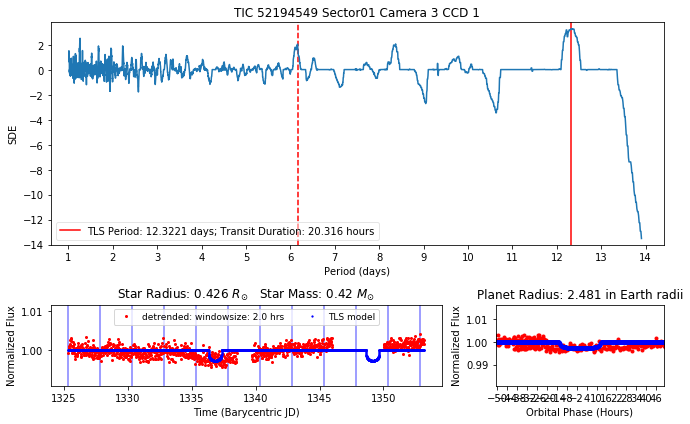

Method 2: GP
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 131 durations
Searching 1067 data points, 4516 periods from 1.01 to 13.906 days
Using all 4 CPU threads


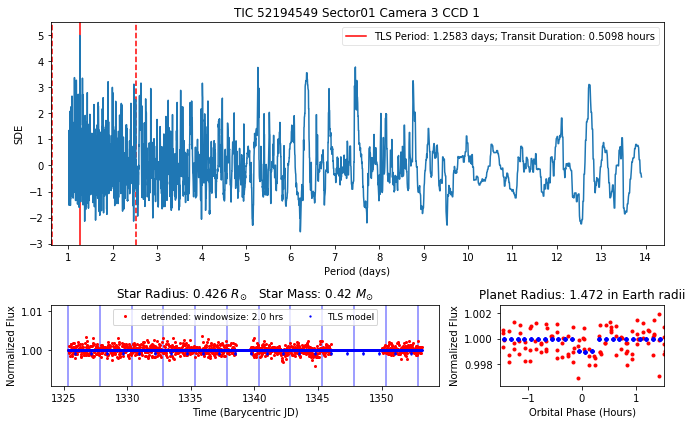

Method 3: SG
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 131 durations
Searching 1067 data points, 4516 periods from 1.01 to 13.906 days
Using all 4 CPU threads


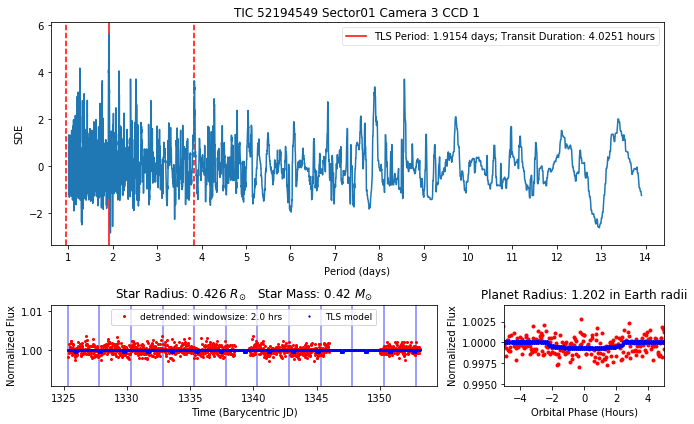

In [161]:

print("Method 1: BWMC")
tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur, R_p, TLS_model_time, TLS_model = TLS_func(ID,t1,f1,e1,minP,minDur,maxDur,N_transits) 
TLS_plot(t1,f1,e1, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, \
         TLS_model_time, TLS_model)


print("Method 2: GP")
tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur, R_p, TLS_model_time, TLS_model = TLS_func(ID,t2,f2,e2,minP,minDur,maxDur,N_transits) 
TLS_plot(t2,f2,e2, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, \
         TLS_model_time, TLS_model)


print("Method 3: SG")
tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_SDE, TLS_Dur, R_p, TLS_model_time, TLS_model = TLS_func(ID,t3,f3,e3,minP,minDur,maxDur,N_transits) 
TLS_plot(t3,f3,e3, tls_power_periods, TLS_SDE, TLS_periods, TLS_t0s, TLS_depths, TLS_Dur, R_p, \
         TLS_model_time, TLS_model)

# None of these look very convincing or similar to original TLS pipeline result: 

original TLS pipeline plot:
 
LS period:  0.6138944717558491
Applying Quasi Periodic GP...
Segment 1 of 3
Segment 2 of 3
Segment 3 of 3
Transit Least Squares TLS 1.0.23 (12 March 2019)
Creating model cache for 131 durations
Searching 1082 data points, 4303 periods from 1.1 to 13.917 days
Using all 4 CPU threads
 
TIC  52194549   1   3   Sector01
best period:  12.029469785565933
best T0:  1330.24478961815


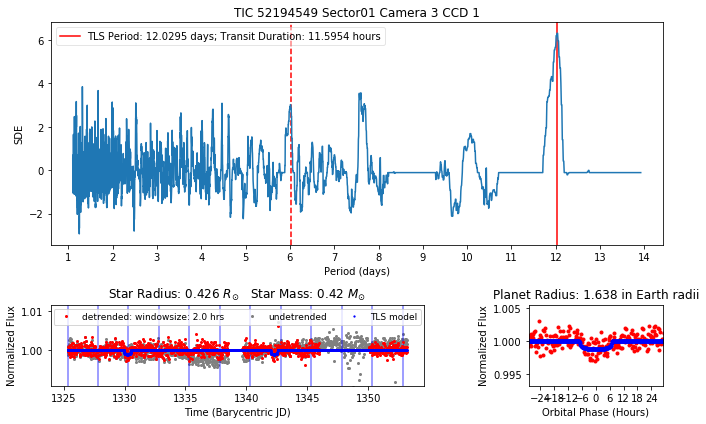

In [163]:
print("original TLS pipeline plot:" )

mask = np.where(np.isfinite(f)==True)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
time = t[mask]                        #Sometimes there are holes in data filled with NaNs
flux = f[mask]
fluxerror = fe[mask]


#known bad data points with high telescope jitter:
SectorNum = int((os.path.basename(match).split)('_')[1][6:])
if SectorNum==1:
    jittermask = (time < 1346) | (time > 1350)
    mdumps=2.5


    t1,f1,fe1 = time[jittermask], flux[jittermask], fluxerror[jittermask]

    t2,f2,fe2=t1,f1,fe1
else:

    t2,f2,fe2=time,flux,fluxerror

if SectorNum==3:
    jittermask = (time < 1382.6) | (time > 1383.65)
    mdumps=3.125

    t1,f1,fe1 = time[jittermask], flux[jittermask], fluxerror[jittermask]

    t2,f2,fe2=t1,f1,fe1

if SectorNum==2:
    mdumps=2.5
    t2,f2,fe2=time,flux,fluxerror     
    
    
    
#check for rapid rotators with Lomb-Scargle (P_rot < 3 days)
period = 10 ** np.linspace(np.log10(0.1), np.log10(3), 1000)
#     period = 10 ** np.linspace(np.log10(0.1), np.log10(80), 1000)
freq = 2.0 * np.pi / period
PS = lomb_scargle(t2,f2,fe2,omega=freq, generalized=True)
Standpower = (PS-np.mean(PS))/np.std(PS)
print(" ")    
print("LS period: ",period[np.argmax(Standpower)])

if period[np.argmax(Standpower)] < 3:

    print("Applying Quasi Periodic GP...")
    length_scale=2 # 1 to 2 is generally pretty good from my tests
    gpflatten_lc, gptrend_lc = flatten(t2,f2,method='gp', \
                                         kernel='periodic_auto',kernel_size=length_scale,return_trend=True,robust=True)

    T=t2
    F= gpflatten_lc
    FE = fe2
    
    T,F,FE = ChauventsCriteron(T,F,FE)
    flatten_lc, trend_lc = flatten(T,F,method='savgol',window_length=241,cval=3,return_trend=True)


    nanmask = np.where(np.isfinite(flatten_lc)==True)[0]
    T = T[nanmask]
    F = flatten_lc[nanmask]/np.mean(flatten_lc[nanmask])
    FE =FE[nanmask]

    window_size_wotan = length_scale/24.0
else:

    print("Applying Biweighted Midcorrelation Function...")
    window_size_wotan = 5.0/24.0 # The length of the filter window in units of time (days)
    flatten_lc, trend_lc = flatten(t2, f2, window_length=window_size_wotan, return_trend=True, break_tolerance=window_size_wotan/2.0,method='biweight',robust=True)
    T=t2
    F=flatten_lc
    FE=fe2

    #checking for NaNs
    nanmask = np.where(np.isfinite(F)==True)[0]
    T = T[nanmask]
    F = F[nanmask]
    FE =FE[nanmask]

    T,F,FE = ChauventsCriteron(T,F,FE)

#checking for NaNs
nanmask = np.where(np.isfinite(F)==True)[0]
T = T[nanmask]
F = F[nanmask]
FE =FE[nanmask]

qld, M_star, M_star_min, M_star_max, R_star, R_star_min, R_star_max = catalog_info(TIC_ID=ID)
spacing = 0.02

SDE_threshold=6.0 #we've been testing different values here (6,6.5,7). For now, let's try sticking with 6.
 
fs = 9

#for reporting TLS model's planet radius
R_earth = 6.378*10.0**8.0 #cm
R_sun = 6.955*10.0**10.0 #cm

if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
    minP=1.1
    maxP= (max(T)-min(T)) #length of our light curve
    minDur = 1.0/24.0
    maxDur = 5.0/24.0

    #creating list of orbital periods to model with
    periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP/3.0)#,oversampling_factor=10)

    durations = np.linspace(minDur,maxDur,25)

    tls = transitleastsquares(T,F,FE)
    tls_power = tls.power(R_star=R_star,period_min=minP,period_max=maxP,show_progress_bar=False,n_transits_min=2,duration_grid_step=1.02)

    #TLS results
    TLS_periods=tls_power.period
    TLS_t0s=tls_power.T0
    TLS_depths=tls_power.depth
    TLS_SDE=tls_power.power
    TLS_Dur = tls_power.duration

    #calculating TLS estimated planet radius
    R_p = np.sqrt(1-TLS_depths)*R_star*R_sun/R_earth

    #creating the best fit box model to our data
    TLS_model_time = tls_power.model_lightcurve_time 
    TLS_model = tls_power.model_lightcurve_model 

    p = TLS_periods
    pf_model = (TLS_model_time - TLS_t0s + 0.5*p) % p - 0.5*p        
    x_fold = (T - TLS_t0s + 0.5*p) % p - 0.5*p
    x_fold_raw = (t - TLS_t0s + 0.5*p) % p - 0.5*p

    detrendedphasefoldedlc = [x_fold, F, FE]
    phasefoldedlc = [x_fold_raw, f, fe]


#     if len(np.where(TLS_SDE>SDE_threshold)[0])>0:
    print(" ")
    print("TIC ", str(ID), " ",CCD, " ",Camera, " ",Sector)
    print("best period: ", TLS_periods)
    print("best T0: ",TLS_t0s)

    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(gs1[:-1, :])
    ax2 = fig.add_subplot(gs1[-1, :-1])
    ax3 = fig.add_subplot(gs1[-1, -1])


    ax1.axvline(x=TLS_periods,color='r',label='TLS Period: '+str( np.round(TLS_periods,4) )+" days; Transit Duration: "+str(np.round(24*TLS_Dur,4))+" hours") #rounding period to 4 decimal places 
    ax1.axvline(x=0.5*TLS_periods,color='r',linestyle='--')
    ax1.axvline(x=2.0*TLS_periods,color='r',linestyle='--') 
    ax1.plot(tls_power.periods, TLS_SDE, rasterized=True)
    plt.xticks(np.arange(0.0, 31.0, 1.0))
    ax1.set_title("TIC "+str(ID)+" "+Sector+" Camera "+Camera+" CCD "+CCD)
    ax1.set_xlabel("Period (days)")
    ax1.set_xticks(np.arange(1.0, 15.0, 1.0))
    ax1.set_xlim(np.min(tls_power.periods)-0.5, np.max(tls_power.periods)+0.5)

    ax1.set_ylabel("SDE")
    ax1.set_ylim(np.min(TLS_SDE)-0.5, np.max(TLS_SDE)+0.5)
    ax1.legend(loc='best',fancybox=True,framealpha=0.5)

    ax2.plot(T, F ,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')#+", binsize: "+str(bin_size)) 
    ax2.plot(t,f,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
    ax2.plot(TLS_model_time,TLS_model,'b.',label='TLS model',markersize=2.5)
    ax2.legend(loc='upper center',ncol=3,fontsize=fs)
    ax2.set_ylim(np.min(F)-5*np.std(F), np.max(F)+5*np.std(F))
    for x in range(12):
        ax2.axvline(x=(T[0]+x*mdumps),color='b',alpha=0.5,zorder=0)
    ax2.set_title("Star Radius: "+str(np.round(R_star,3))+r" $R_{\odot}$   Star Mass: "+str(np.round(M_star,3))+r" $M_{\odot}$")

    ax2.set_xlabel("Time (Barycentric JD)")
    ax2.set_ylabel("Normalized Flux") 

    ax3.plot(24*x_fold,detrendedphasefoldedlc[1],c='red',markersize=6,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size_wotan*24)+' hrs')
    ax3.plot(24*pf_model,TLS_model,'b.',label='TLS model',markersize=5)
    ax3.set_xlabel("Orbital Phase (Hours)")
    ax3.set_ylabel("Normalized Flux") 
    ax3.set_title("Planet Radius: "+str(np.round(R_p,3))+" in Earth radii")
    ax3.set_ylim(np.min(TLS_model)-25*np.std(TLS_model), np.max(TLS_model)+25*np.std(TLS_model))
    ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours

    if TLS_Dur*24> 8.0:
        ax3.set_xticks(np.arange(np.round(-14*TLS_Dur*24.0),np.round(14*TLS_Dur*24.0),6)) #hours
        ax3.set_xlim(-2.5*TLS_Dur*24,2.5*TLS_Dur*24)

    else:
#                     TLS_Dur*24< 1.0 and TLS_Dur*24< 8.0:
        ax3.set_xticks(np.arange(np.round(-7*TLS_Dur*24.0),np.round(7*TLS_Dur*24.0),2)) #hours
        ax3.set_xlim(-5,5)

    if TLS_Dur*24< 1.0:
        ax3.set_xticks(np.arange(np.round(-15*TLS_Dur*24.0),np.round(15*TLS_Dur*24.0),1.)) #hours
        ax3.set_xlim(-3*TLS_Dur*24,3*TLS_Dur*24)

    gs1.tight_layout(fig)

#             plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_TLS.png")
    plt.show()    


# With the momentum dumps removed and re-detrended, this initial "detection" is no more